In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns

import altair as alt

# Disable max rows to allow for Altair visualisations
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
housesMAR = pd.read_csv('houses_0.5_MAR.csv')

## Plotting Utility

In [3]:
## plotting utility

import matplotlib.pyplot as plt
import numpy as np
from math import ceil

##
## type= {boxplot, kdeplot}
##
def plot_distributions(data, columns, type='boxplot', title=None):

    print("plotting columns {c}".format(c=list(columns)))

    if type not in {'boxplot', 'dkeplot'}:
        print("type= {boxplot, dkeplot} only are supported")
        return

    ## grid size depends on number of columns
    ## max 4 columns in the grid
    maxCols  = 4

    if len(columns) < 4:
        numCols = len(columns)
    else:
        numCols = maxCols
    numRows = ceil(len(columns) / 4)

    print("grid is {0}x{1}".format(numRows, numCols))

    fig, axs = plt.subplots(numRows, numCols)
    fig.suptitle(title)
    fig.set_figwidth(5*numCols)
    fig.set_figheight(3*numCols)
    fig.tight_layout(pad=5.0)

    print(axs)

#         handle special axes
    if numRows == 1 and numCols == 1:
        c = columns[0]
        # axes is a scalar
        if type == 'boxplot':
            sns.boxplot(data=data, x=c, ax=axs)
        else:
            sns.kdeplot(data=data, x=c, ax=axs)
        axs.set_title(c)

    elif numRows == 1:
        i = 0
        # axes is a 1D array
        for c in columns:
#         print("column {c}".format(c=c))
            if type == 'boxplot':
                sns.boxplot(data=data, x=c, ax=axs[i])
            else:
                sns.kdeplot(data=data, x=c, ax=axs[i])
            axs[i].set_title(c)
            i = i+1

    else:
    # general case of a 2D grid
        i=j=0
        for c in columns:
            print("column {c}".format(c=c))
            if type == 'boxplot':
                print("plotting on axes [{0},{1}]".format(i,j))
                sns.boxplot(data=data, x=c, ax=axs[i,j])
            else:
                sns.kdeplot(data=data, x=c, ax=axs[i,j])

            axs[i,j].set_title(c)
            j = j+1
            if j == 4:
                i = i+1
                j= 0


# Objective

Within this notebook we look to investigate the dataset for missing data through ad hoc Exploratory Data Analysis (EDA). If missing data arises, we will look to examine the missing data, deciding whether or not to impute the data. If the need for imputation arises, we will look to utilise KNN imputation and MICE imputation. Following this, we will then look to utilise the machine learning model Linear Regression to conduct a comparative analysis on the two imputation methods, ultimately choosing the best method.

</br>

## Data Understanding

First we will begin by performing descriptive analytics, looking at the raw statistics.

In [3]:
housesMAR.head()

Unnamed: 0  median_house_value  median_income  housing_median_age  \
0           0            452600.0         8.3252                41.0   
1           1            358500.0         8.3014                21.0   
2           2            352100.0         7.2574                52.0   
3           3            341300.0         5.6431                52.0   
4           4            342200.0         3.8462                52.0   

   total_rooms  total_bedrooms  population  households  latitude  longitude  
0        880.0           129.0         NaN       126.0     37.88    -122.23  
1       7099.0          1106.0         NaN      1138.0     37.86    -122.22  
2       1467.0           190.0         NaN       177.0     37.85    -122.24  
3       1274.0           235.0         NaN       219.0     37.85    -122.25  
4       1627.0           280.0       565.0       259.0     37.85    -122.25

In [4]:
housesMAR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          20640 non-null  int64  
 1   median_house_value  20640 non-null  float64
 2   median_income       10320 non-null  float64
 3   housing_median_age  10320 non-null  float64
 4   total_rooms         20640 non-null  float64
 5   total_bedrooms      20640 non-null  float64
 6   population          10320 non-null  float64
 7   households          20640 non-null  float64
 8   latitude            20640 non-null  float64
 9   longitude           20640 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.6 MB


In [ ]:
housesMAR.describe()

Unnamed: 0  median_house_value  median_income  housing_median_age  \
count  20640.000000        20640.000000   10320.000000        10320.000000   
mean   10319.500000       206855.816909       3.940372           27.649128   
std     5958.399114       115395.615874       1.915848           13.294325   
min        0.000000        14999.000000       0.499900            1.000000   
25%     5159.750000       119600.000000       2.603300           17.000000   
50%    10319.500000       179700.000000       3.601950           26.000000   
75%    15479.250000       264725.000000       4.835600           37.000000   
max    20639.000000       500001.000000      15.000100           52.000000   

        total_rooms  total_bedrooms    population    households      latitude  \
count  20640.000000    20640.000000  10320.000000  20640.000000  20640.000000   
mean    2635.763081      537.898014   1352.802229    499.539680     35.631861   
std     2181.615252      421.247906   1074.226167    382.329753      2.135952   
min        2.000000        1.000000      5.000000      1.000000     32.540000   
25%     1447.750000      295.000000    748.000000    280.000000     33.930000   
50%     2127.000000      435.000000   1127.000000    409.000000     34.260000   
75%     3148.000000      647.000000   1654.000000    605.000000     37.710000   
max    39320.000000     6445.000000  35682.000000   6082.000000     41.950000   

          longitude  
count  20640.000000  
mean    -119.569704  
std        2.003532  
min     -124.350000  
25%     -121.800000  
50%     -118.490000  
75%     -118.010000  
max     -114.310000

From a brief analysis of the dataset, it becomes evident that there is a column which is unnamed. The absence of a column name presents a challenge in interpreting the data it contains, as it is not possible to show its signifigance or relevance.

Rather than simply dropping the column straight-away, we will conduct a breif investigation. If the investigation is successful, we will then be able to provide the column with an appropriate column name. If not, we will then drop the column, as it's unclear data will not be useful for our goals.

In [ ]:
housesMAR['Unnamed: 0'].head()

0    0
1    1
2    2
3    3
4    4
Name: Unnamed: 0, dtype: int64

In [ ]:
housesMAR['Unnamed: 0'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20640 entries, 0 to 20639
Series name: Unnamed: 0
Non-Null Count  Dtype
--------------  -----
20640 non-null  int64
dtypes: int64(1)
memory usage: 161.4 KB


In [ ]:
housesMAR['Unnamed: 0'].describe()

count    20640.000000
mean     10319.500000
std       5958.399114
min          0.000000
25%       5159.750000
50%      10319.500000
75%      15479.250000
max      20639.000000
Name: Unnamed: 0, dtype: float64

In [ ]:
housesMAR['Unnamed: 0']

0            0
1            1
2            2
3            3
4            4
         ...  
20635    20635
20636    20636
20637    20637
20638    20638
20639    20639
Name: Unnamed: 0, Length: 20640, dtype: int64

In [ ]:
alt.Chart(housesMAR).mark_point().encode(
    alt.X('Unnamed: 0', bin=alt.Bin(maxbins=1000)),
    y='count()'
)

alt.Chart(...)

Inspecting the data, specifically when outputting the contents of the Unnamed column, it becomes clear that the column is sequentially numbering the rows.

Knowing this information, we are now able to confidently remove the column, as it does not contain any crucial or important data.

In [6]:
housesMAR = housesMAR.drop('Unnamed: 0', axis=1)

housesMAR.columns

Index(['median_house_value', 'median_income', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude',
       'longitude'],
      dtype='object')

## Data Understanding Continued
After gaining a grasp of some of the raw statistical elements of the dataset, it is now time to conduct basic visualisations of the dataset to help outline the data distribution. This is used to gain a better understanding of the data we are working with, in order to allow us to make more informed decisions.

</br>

I will use the provided plotting utility in the form of box plots for each of the values as an initial starting point.


plotting columns ['median_house_value', 'median_income', 'housing_median_age']
grid is 1x3
[<Axes: > <Axes: > <Axes: >]


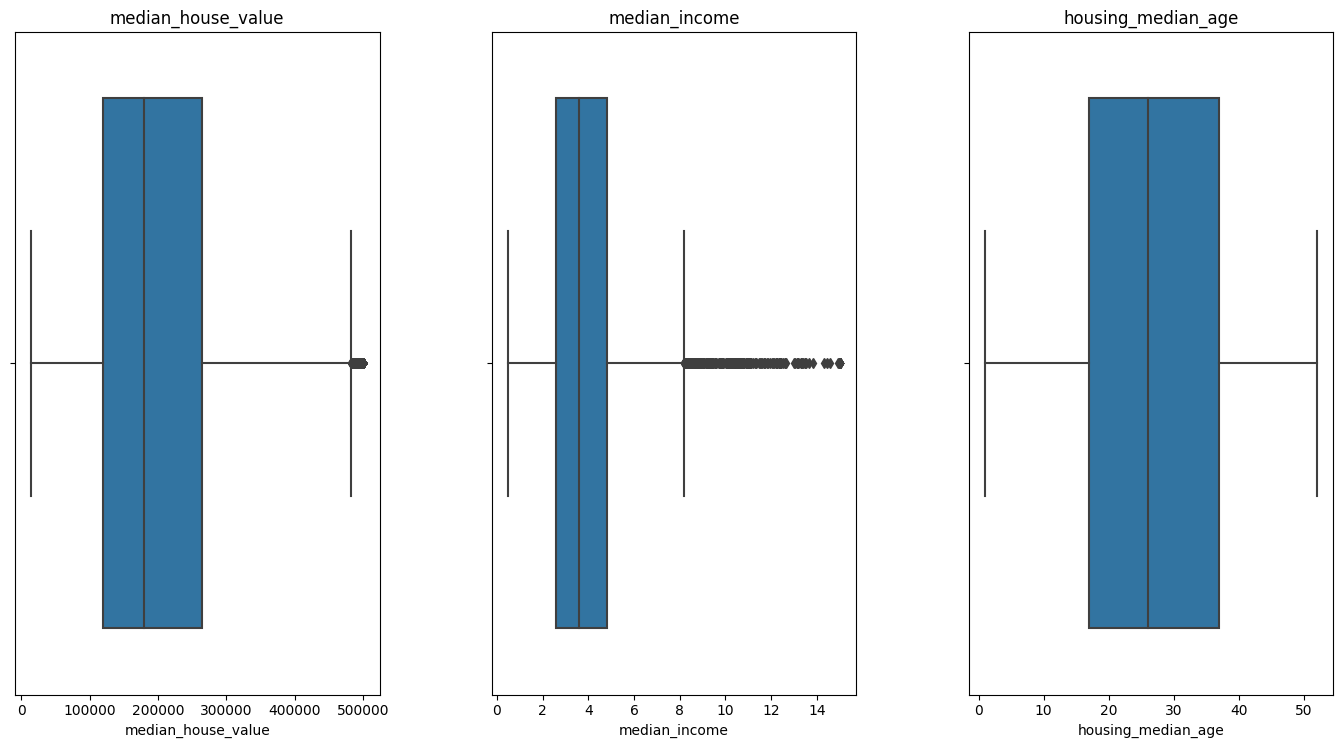

In [ ]:
plot_distributions(housesMAR, ['median_house_value', 'median_income', 'housing_median_age'])

plotting columns ['total_rooms', 'total_bedrooms']
grid is 1x2
[<Axes: > <Axes: >]


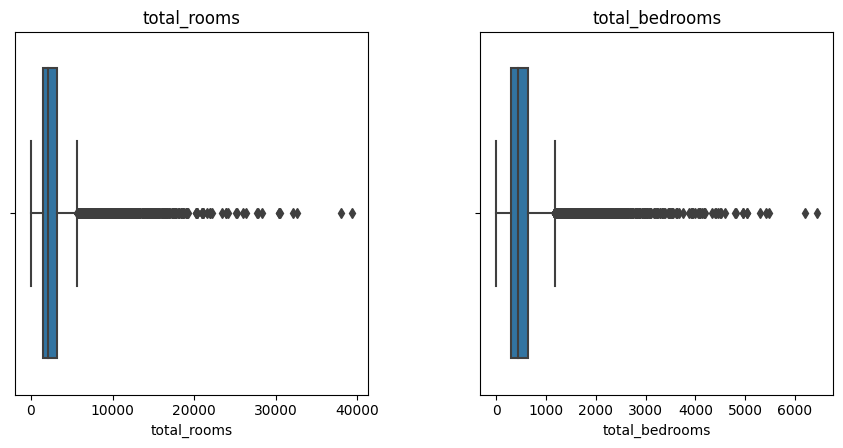

In [ ]:
plot_distributions(housesMAR, ['total_rooms', 'total_bedrooms'])

plotting columns ['population', 'households', 'latitude', 'longitude']
grid is 1x4
[<Axes: > <Axes: > <Axes: > <Axes: >]


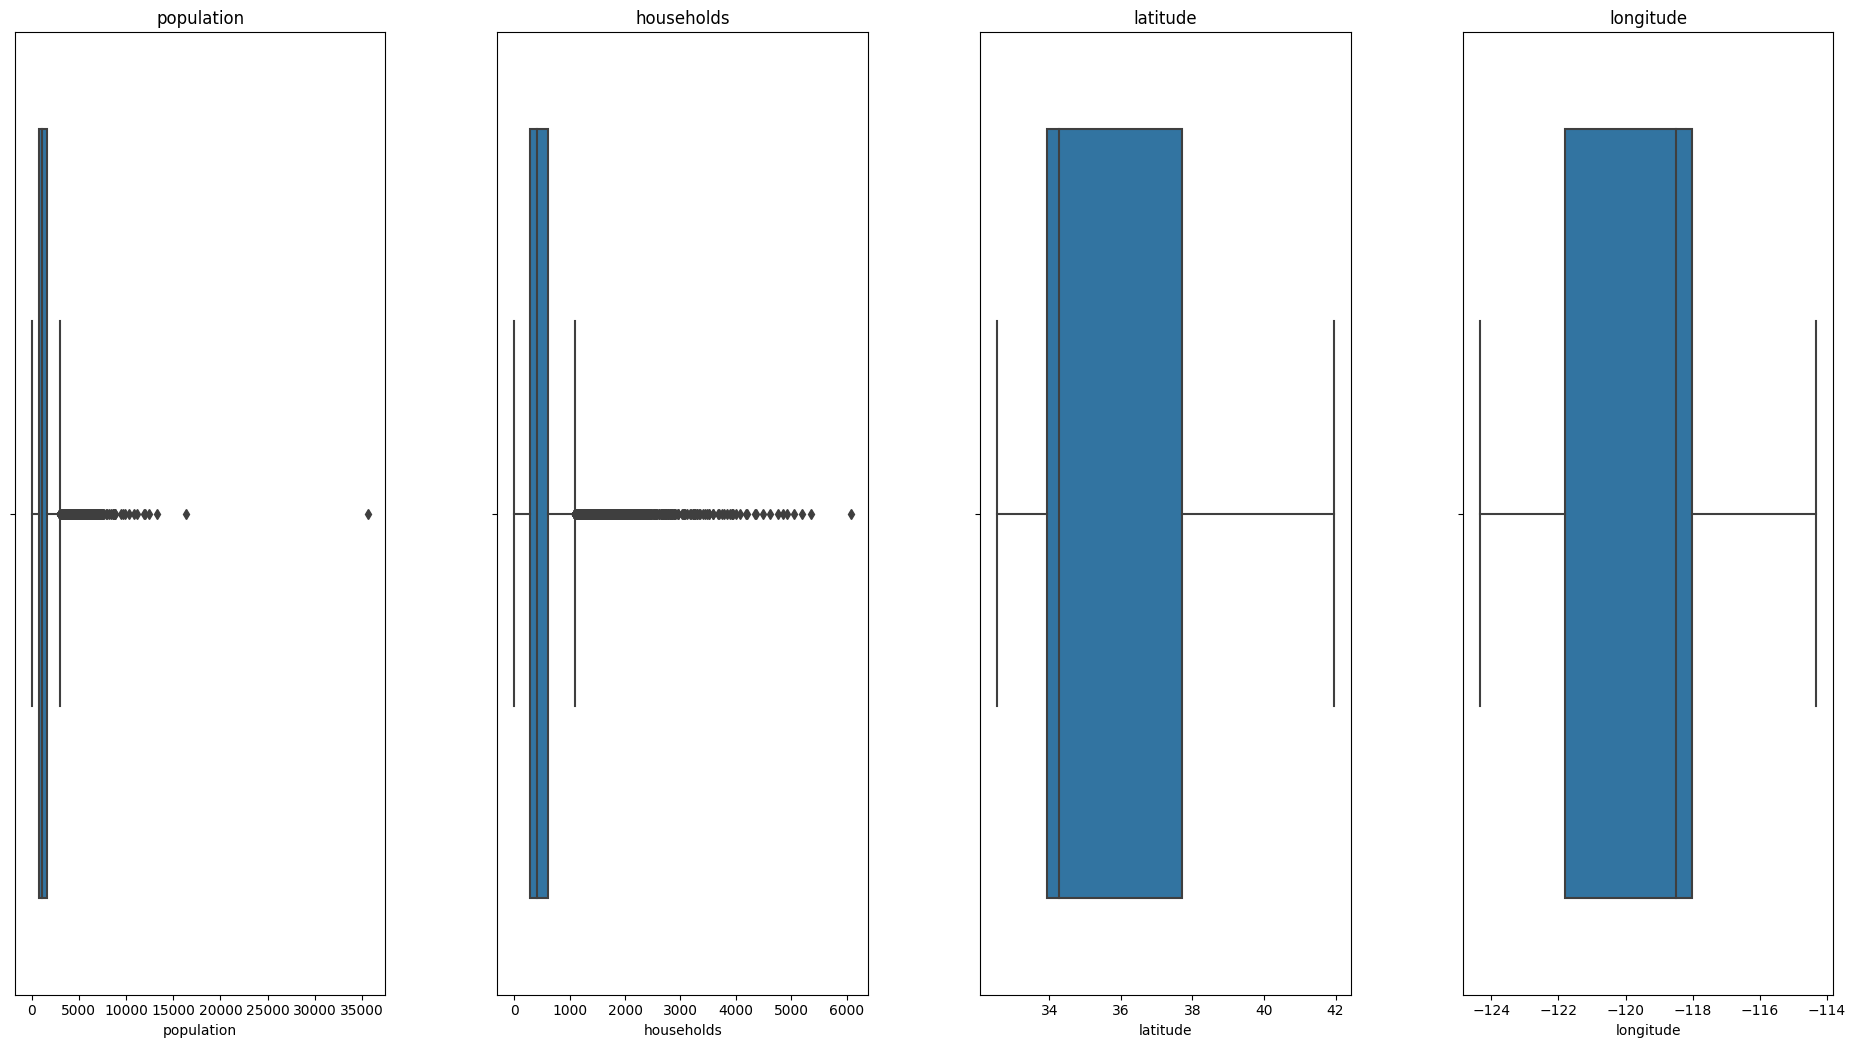

In [ ]:
plot_distributions(housesMAR, ['population', 'households', 'latitude', 'longitude'])

From analysing the provided diagrams it is possible to view many columns with right-skewed distributions. A right-skew distribution, also known as positive skewness, is characterised by a tail that extends to the right, indicating that a subset of data points stretches out beyond the main concentration of data.

While boxplots provide indication of skewness, they are not as explicit as histograms at displaying the distribution of data. As such, to better illustrate and confirm the presence of right-skewed distributions, we will proceed to utilise histograms.

In [7]:
base = alt.Chart(housesMAR).mark_bar().encode(
    y='count()'
)

alt.vconcat(
    base.encode(alt.X('median_house_value', bin=True)),
    base.encode(alt.X('median_income', bin=True)),
    base.encode(alt.X('housing_median_age')),
    base.encode(alt.X('total_rooms')),
    base.encode(alt.X('total_bedrooms')),
    base.encode(alt.X('population')),
    base.encode(alt.X('households')),
    base.encode(alt.X('latitude')),
    base.encode(alt.X('longitude'))
)

alt.VConcatChart(...)

As inferred from the boxplots, the historgrams reinforce what we suggested, in that the data in several columns display a right-skew distribution. This skewness is more pronouced in certain columns than in others.

Having established an initial understanding of the distribution characteristics across various columns, the next step in our analysis is to check for any missing values present.

## Checking for Missing Data

In [8]:
housesMAR.isnull().sum()

median_house_value        0
median_income         10320
housing_median_age    10320
total_rooms               0
total_bedrooms            0
population            10320
households                0
latitude                  0
longitude                 0
dtype: int64

Looking at the missing data, it becomes apparent there are three columns which require further attention. As such, we will calculate the percent of missing data inside these three columns. From doing so, we will gain a better understanding of the missing data, and this will allow us to make a more informed decision for future analysis.

In [9]:
housesMAR.isnull().sum() * 100 / len(housesMAR)

median_house_value     0.0
median_income         50.0
housing_median_age    50.0
total_rooms            0.0
total_bedrooms         0.0
population            50.0
households             0.0
latitude               0.0
longitude              0.0
dtype: float64

Having observed that three columns in the dataset (Median Income, Housing Median Age, and Population) each have 50% missing data, we need to make a decision regarding there retention or removal. Given that the dataset pertains to housing, the signifigance of these columns is immediately apparent. The columns pivotal roles in providing insights into the housing market makes a compelling case for their preservation.

However, the presence of such a high level of missing data cannot be ignored. To proceed with these columns, we must address the gaps in data. If not, the missing data could potentially compromise the itegrity of the data present.

Therefore, it becomes apparent that imputation methods are required to allow us to reconstruct the missing information in a statistically sound manner. For this, we will utilise two highly regarded imputation methods:
- K-Nearest Neighbours (KNN) Imputation
- Multiple Imputation by Chained Equations (MICE)

By applying these two methods, we aim to fill in the missing values and then evaluate their performance. Ultimately, the final step will then be to conduct statistical analysis to determine the most effective imputation method against the complete dataset, ensuring the integrity and utility of the imputed data.

In [10]:
columns_to_impute = ['median_income', 'housing_median_age', 'population']

imputation_data = housesMAR[columns_to_impute]

## KNN Imputation

(scikit-learn.org, n.d)

In [11]:
from sklearn.impute import KNNImputer

In [12]:
knn_imputer = KNNImputer(n_neighbors=5)

imputed_data_knn = knn_imputer.fit_transform(imputation_data)

KNN_Imputed = pd.DataFrame(imputed_data_knn, columns=columns_to_impute)

KNN_Imputed.isnull().sum()

median_income         0
housing_median_age    0
population            0
dtype: int64

Through utilising KNN Imputation, we were able to sucessfully impute all of the missing values. This can be shown by the printed result, showcasing 0 missing values for all 3 columns, which previously contained 10320 missing values each.

For the implimentation of KNN imputation, it is worth noting the use of 5 nearest neighbours (K = 5). This number was set as through testing different values of K, the number five provided the best performance. Through using K = 5, we were able to create a balance of avoiding underfitting whilst also avoiding overfitting, maintaining statistical stability.  

Now it is time to concatenate the imputation data created using K-Nearest Neighbours back into the original dataset. This will be done by first removing the columns containing missing values to aviod duplication, and reinserting the KNN imputation results. Lastly, we will check to make sure that there are no missing values inside the new dataset.

In [13]:
housesMAR_without_missing = housesMAR.drop(columns=columns_to_impute)

housesMAR_KNN = pd.concat([housesMAR_without_missing, KNN_Imputed], axis=1)

housesMAR_KNN.isnull().sum()

median_house_value    0
total_rooms           0
total_bedrooms        0
households            0
latitude              0
longitude             0
median_income         0
housing_median_age    0
population            0
dtype: int64

## Using Linear Regression to Evaluate Performace of KNN Imputation

Having completed KNN imputation and added the imputed data back into the original dataset, we will now apply a linear regression model to predict the median house value. This step will allow us to evaluate the effectiveness of our chosen imputation method.

Note:</br>
Since we are aware that we will be using another imputation method in the form of MICE for comparison, the decision was made to impliment the linear regression model and associated visualisation in the form of a function.

As such, we will be able to utilise the same regressional model and visualisation for both KNN and MICE, allowing for consistency and the ability to solely compare the results provided by the two imputation methods.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

(Dixon, 2023)

(scikit-learn developers, 2019)

In [15]:
def build_and_evaluate_model(data, target_column):
    X = data.drop(columns=[target_column])
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    plot_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

    actual_plot = alt.Chart(plot_data).mark_circle(size=10, opacity=0.5, color='blue').encode(
        alt.X('Actual:Q', bin=alt.Bin(maxbins=50), axis=alt.Axis(title='Actual (Blue), Predicted (Red)')),
        alt.Y('Predicted:Q', bin=alt.Bin(maxbins=50)),
        alt.Size('count()', scale=alt.Scale(range=[0, 100]), legend=None),
        tooltip=['Actual', 'Predicted']
    ).properties(
        title='Linear Regression Imputation Results',
        width=600,
        height=400
    )

    predicted_plot = alt.Chart(plot_data).mark_circle(size=10, opacity=0.5, color='red').encode(
        alt.X('Predicted:Q', bin=alt.Bin(maxbins=50)),
        alt.Y('Actual:Q', bin=alt.Bin(maxbins=50), axis=alt.Axis(title='Predicted (Red), Actual (Blue)')),
        alt.Size('count()', scale=alt.Scale(range=[0, 100]), legend=None),
        tooltip=['Predicted', 'Actual']
    ).properties(
        width=600,
        height=400
    )

    combined_plot = actual_plot + predicted_plot
    combined_plot.display()


    return mse, r2

In [16]:
knn_mse, knn_r2 = build_and_evaluate_model(housesMAR_KNN, 'median_house_value')
print("KNN Imputed Data - MSE:", knn_mse, ", R2 Score:", knn_r2)

alt.LayerChart(...)

KNN Imputed Data - MSE: 7814863386.232155 , R2 Score: 0.40363172749908427


Analysing the graph shown above, and comparing the actual median house values against the predicted median house values using the KNN imputed data and regressional model, it is possible to visualise the imputation methods effectiveness.

Looking at the visualisation, it is possible to distinguish that the vast majority of the predicted data points are accurate, with most predicted values inside the cluster of data.

However, it is worth noting that the axises for the two combined graphs are swapped. In doing so, we provide a unique perspective on the data, enabling us to highlight discrepancies between actual and predicted values more distinctly. To help discern the differences, a tooltip feature has been implimented to the graph, allowing the user to hover over a specific data point in the graph, where additional information is provided, such as the data points actual and predicted value. Overall, through using this visual arrangement, it makes it easier to identify and analyse outliers.

Through using this graph it can then be inferred that the KNN imputation method underestimated a handful of data points. This can be shown by the presence of predicted data points further to the left of the data distribution, whilst many of the actual data points on the outer-most right are without predicted data points near. Using the tooltip feature, we can then confirm this by hovering over a data point either to the far left or right of the graph, identifying the stark difference in actual and predicted values.

## MICE Imputation

Now that we have analysed the implimentation of the K-Nearest Neighbour imputation method and its overall effectivness, it is time to include another imputation method, to allow for further comparison. In doing so, we will be able to further compare KNN's performance whilst also discovering the best imputation method for the given dataset.

With this in mind, we have chosen MICE (Mutliple Imputation by Chained Equations) Imputation as our second method. MICE imputation utilises an iterative approach, where each variable with missing data is modeled conditionally against others in a round-robin fashion. It is a popular imputation method due to its efficiency when compared to KNN and also its overall performance (scikit-learn, n.d).

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [18]:
mice_imputer = IterativeImputer(max_iter=10, random_state=0)

imputed_data_mice = mice_imputer.fit_transform(imputation_data)

MICE_Imputed = pd.DataFrame(imputed_data_mice, columns=columns_to_impute)

MICE_Imputed.isnull().sum()

median_income         0
housing_median_age    0
population            0
dtype: int64

By employing MICE (Mutliple Imputation by Chained Equations) Imputation, we have addressed the missing values across the three columns. The output, which indicates zero missing values for the three previously incomplete columns, showcases the methods success.

Note:
For the implimentation of MICE, we configured the imputer to perform a series of 10 iterations, allowing for the refinement of estimates with each pass. Furthermore, the choice of 10 iterations was determined through testing a range of numbers, striving for the best performance.

Similarly to the KNN imputation method, after sucessfully implimenting the method, it is now time to group the imputed data from MICE back into the original dataset. For this, we will follow the same process which we did when using KNN's results.

In [19]:
housesMAR_without_missing = housesMAR.drop(columns=columns_to_impute)

housesMAR_MICE = pd.concat([housesMAR_without_missing, MICE_Imputed], axis=1)

housesMAR_MICE.isnull().sum()

median_house_value    0
total_rooms           0
total_bedrooms        0
households            0
latitude              0
longitude             0
median_income         0
housing_median_age    0
population            0
dtype: int64

## Using Linear Regression to Evaluate Performace of MICE Imputation

Now that we have the new dataset containing the MICE imputation data points, we now need to compare the predicted results against the actual results utilising the same linear regression model (Dixon, 2023).

In [20]:
mice_mse, mice_r2 = build_and_evaluate_model(housesMAR_MICE, 'median_house_value')
print("MICE Imputed Data - MSE:", mice_mse, ", R2 Score:", mice_r2)

alt.LayerChart(...)

MICE Imputed Data - MSE: 7527834597.889675 , R2 Score: 0.42553548373920014


Analysing the visualisation, and comparing the actual median house values against the predicted median house values using the MICE imputed data and regressional model, it becomes difficult to discern any meaningful difference between the graph using KNN imputed data.

Similarly to the visualisation produced using the KNN imputed data, it can be inferred that the MICE imputed data has been underestimated in proportion to the actual data points. When analysing the visualisation, it is possible to see many of the predicted data points located further to the left of the data cluster. When looking to the right of the graph, the opposite seems to occur, with many of the predicted data points not present, whilst many actual data points are.

Whilst it is difficult to compare the two imputation methods performance using visualisations, it is possible to discern a difference between the two methods when analysing their Mean Squared Error (MSE) and R2 Score.

| Imputation Method | Mean Squared Error (MSE) | R2 Score        |
|-------------------|--------------------------|-----------------|
| MICE              | 7527834597.889675        | 0.4255354837392 |
| KNN               | 7814863386.232155        | 0.4036317274991 |

Knowing that an MSE score closer to zero indicates better performance and that an R2 score ranges between 0 to 1, with high values indicating better fit, we are able to discern which method performed better.

Looking at the table provided above, it is possible to then discover that the MICE imputation method performed better when compared to KNN imputation.

However, for a more detailed analysis, we will now delve deeper into the comparison between the two imputation methods. This is in an attempt to truly discover which method is best, utilising more statistical analysis tools.

## KNN Imputation vs MICE Imputation

Having implimented two imputation methods (KNN and MICE), we can now proceed to evaluate their performance. This comparative analysis will help determine which method is the most reliable for data restoration in the given dataset.

Through statistical comparison, using the complete dataset as the benchmark for accuracy, we will be able to measure how close each method is to the true values in the dataset.

In [21]:
complete_data = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv')

complete_data.isnull().sum()

median_house_value    0
median_income         0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
latitude              0
longitude             0
dtype: int64

As discovered in previous analysis, only three of the columns contain missing data. As such, we only require the complete data pertaining to these three columns.

In [22]:
complete_data = complete_data[columns_to_impute]

In order to first gain a prespective as to the imputation method's performance, we will calculate the mean and standard deviation for the complete data, KNN data and MICE data.

Doing so will give us an insight into which method performed the best.

In [23]:
complete_stats = complete_data.describe().T[['mean', 'std']]

knn_stats = KNN_Imputed.describe().T[['mean', 'std']]

mice_stats = MICE_Imputed.describe().T[['mean', 'std']]

comparison_stats = pd.concat([complete_stats, knn_stats, mice_stats], axis=1)
comparison_stats.columns = ['Complete Mean', 'Complete Std', 'KNN Mean', 'KNN Std', 'MICE Mean', 'MICE Std']

comparison_stats

Complete Mean  Complete Std     KNN Mean     KNN Std  \
median_income            3.870671      1.899822     4.023619    1.501311   
housing_median_age      28.639486     12.585558    27.561286    9.711511   
population            1425.476744   1132.462122  1361.384876  778.065231   

                      MICE Mean    MICE Std  
median_income          3.943323    1.365003  
housing_median_age    27.537990    9.608643  
population          1456.320818  792.278345

Looking at the results it seems that the MICE imputation maintains the mean closer to the complete data for median_income and population, meaning that the MICE imputation performed better in this regard. However, both imputation methods result in a mean that is lower for housing_median_age, indicating that imputation slightly underestimated the average age and reduced variability.

Standard deviation is concistently lower in the imputed data, which may indicate that both methods tend to generate less variability than what is present in the complete data.

With no clear winner discovered at this stage, more statistical analysis will need to be conducted to gain more insight into the two methods overall performance (scikit-learn.org, n.d).

In [24]:
KNN_MAD = abs(KNN_Imputed.mean() - complete_data.mean())
MICE_MAD = abs(MICE_Imputed.mean() - complete_data.mean())

KNN_Std = abs(KNN_Imputed.std() - complete_data.std())
MICE_Std = abs(MICE_Imputed.std() - complete_data.std())

KNN_MSD = (KNN_Imputed.mean() - complete_data.mean()) ** 2
MICE_MSD = (MICE_Imputed.mean() - complete_data.mean()) ** 2

In [25]:
comparison_metrics = pd.concat({
    'KNN': pd.DataFrame({
        'MAD': KNN_MAD,
        'StdDev': KNN_Std,
        'MSD': KNN_MSD
    }),
    'MICE': pd.DataFrame({
        'MAD': MICE_MAD,
        'StdDev': MICE_Std,
        'MSD': MICE_MSD
    })
}, axis=1)

comparison_metrics

KNN                                MICE              \
                          MAD      StdDev          MSD        MAD      StdDev   
median_income        0.152948    0.398511     0.023393   0.072652    0.534819   
housing_median_age   1.078200    2.874047     1.162516   1.101496    2.976915   
population          64.091868  354.396891  4107.767544  30.844074  340.183777   

                                
                           MSD  
median_income         0.005278  
housing_median_age    1.213293  
population          951.356874

Analysing the table, and looking at each column in the dataset, it is possible to determine which imputation method performed the best, per column.

Looking at the 'median_income', we can determine that MICE performed the best. This can be indicated through looking at both the MAD and StdDev scores which are lower for MICE than for KNN, showing that MICE performed better in terms of maintaining a distribution close to the original data for this column.

For 'housing_median_age', the MAD and StdDev scores are slightly higher for MICE than for KNN, which suggests that KNN has performed slightly better for this column.

Lastly, for 'population', MAD, StdDev and MSD are considerably lower for MICE compared to KNN, indicating that MICE has a much tighter distribution around the mean for this column.

Overall, through this statistical analysis, it appears that MICE is performing better for 'median_income' and 'population', while KNN is slightly better for 'housing_median_age', based on these measurements. As such, a strong arguement can be made that MICE is the preffered imputation method for this given dataset.


### Visualising The Metrics

In [26]:
melt_metrics = comparison_metrics.reset_index().melt(
    id_vars=['index'],
    var_name=['Imputation Method', 'Metric'],
    value_name='Value'
)

In [27]:
def create_chart(column):
    column_data = melt_metrics[melt_metrics['index'] == column]

    return alt.Chart(column_data).mark_bar().encode(
        x=alt.X('Metric:N', axis=alt.Axis(title='Metric')),
        y=alt.Y('Value:Q', axis=alt.Axis(title='Value'), scale=alt.Scale(zero=False)),
        color='Imputation Method:N',
        tooltip=['Imputation Method', 'Metric', 'Value']
    ).properties(
        width=300,
        height=400,
        title=f'{column}'
    )

chart_median_income = create_chart('median_income')
chart_housing_median_age = create_chart('housing_median_age')
chart_population = create_chart('population')

combined_chart = chart_median_income | chart_housing_median_age | chart_population
combined_chart.display()


alt.HConcatChart(...)

Analysing the visualisations, it is possible to reinforce what was inferred from the table.

Looking at the first chart (median_income), it is shown that KNN (Blue) is more prominent. This indicates KNN's MAD and MSD scores being larger, indicating a poor performance. However, it is worth noting that StdDev for this column, KNN performs marginally better.

Looking at the second chart (housing_median_age), it is shown that KNN performs better in all metrics. However, the margin is rather small.

Lastly, looking at the third chart (population), it is clear to see that MICE outperformed KNN in all metrics.

## Summary

In this notebook we undertook a comrehensive analysis to evaluate the effectiveness of two different imputation methods:

- K-Nearest Neighbours (KNN)
- Multiple Imputation by Chained Equations (MICE)

Initially, Exploratory Data Analysis (EDA) revealed that three columns had 50% missing data, leading to the use of these imputation techniques.

After applying KNN, we then utilised linear regression to predict 'median_house_value', aiming to assess the effectiveness of the imputation method. Once analysed, we introduced the second imputation method, MICE. Following the same steps, the same linear regression model was used to assess the effectivness of MICE. Using the same regression model, we were then able to compare and contrast these two imputation methods more thoroughly, determining that MICE performed better at this stage.

Further statistical analysis using Mean Absolute Deviation (MAD), Mean Squared Deviation (MSD), and Standard Deviation (StdDev) reinforced this finding, with MICE performing better in two of the three imputed columns. Overall, through this analysis, we can suggest that MICE is the more effective imputation method for this dataset.


# References

Dixon, I. (2023) ‘Data Imputation: Dealing with Missing Data’ [Lecture], CSC3831: Predictive Analytics, Computer Vision & AI. Newcastle University. 02 Oct.

<br>

Dixon, I. (2023) ‘Imputation’ [Practical], CSC3831: Predictive Analytics, Computer Vision & AI. Newcastle University. 04 Oct.

<br>

Dixon, I. (2023) ‘Linear Regression Part A’ [Lecture], CSC3831: Predictive Analytics, Computer Vision & AI. Newcastle University. 19 Oct.

<br>

Dixon, I. (2023) ‘Linear Regression Part B’ [Lecture], CSC3831: Predictive Analytics, Computer Vision & AI. Newcastle University. 19 Oct.

<br>

scikit-learn.org. (n.d.). sklearn.impute.KNNImputer — scikit-learn 0.23.1 documentation. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html [Accessed 20 Oct. 2023]

<br>

scikit-learn. (n.d.). sklearn.impute.IterativeImputer. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html [Accessed 20 Oct. 2023]

<br>

scikit-learn developers (2019). sklearn.linear_model.LinearRegression — scikit-learn 0.22 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html [Accessed 23 Oct. 2023]

<br>

scikit-learn.org. (n.d.). 3.5. Model evaluation: quantifying the quality of predictions — scikit-learn 0.15-git documentation. [online] Available at: https://scikit-learn.org/0.15/modules/model_evaluation.html [Accessed 23 Oct. 2023]
